# Handwritten digit classification 


In [1]:
import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


## 0. load data

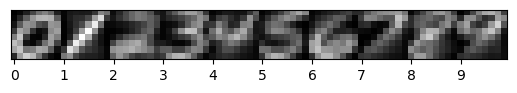

In [2]:
# load the data & plot the means
train_data, train_labels, test_data, test_labels = data.load_all_data_from_zip('a3digits.zip','loaded_data/')
# for i in [train_data, train_labels, test_data, test_labels]:
#     print(i.shape)

def plot_means(train_data, train_labels):
    means = []
    for i in range(0, 10):
        i_digits = data.get_digits_by_label(train_data, train_labels, i)
        # Compute mean of class i
        means.append(np.mean(i_digits, axis=0).reshape(8,8))

    # Plot all means on same axis
    all_concat = np.concatenate(means, 1)
    plt.imshow(all_concat, cmap='gray')
    plt.yticks([])
    plt.xticks(ticks=np.arange(0,73,8),labels=range(10))
    plt.show()

plot_means(train_data, train_labels)

## 1. Multi-Layer Perceptron Classifier
(pending)

## 2. Conditional Gaussian Classifier Training
### 2.a implementation of the conditional gaussian classifier

In [3]:
# starter code & functions 

def make_train_df(train_data, train_labels):
    data_df = pd.DataFrame(train_data)
    labels_df = pd.DataFrame(train_labels, columns=['label'])
    train_df = pd.concat([data_df, labels_df], axis=1)
    return train_df

def compute_mean_mles(train_data, train_labels):
    '''
    make sure the inputs are both np.arrays
    Compute the mean estimate for each digit class

    Should return a numpy array of size (10,64)
    The ith row will correspond to the mean estimate for digit class i
    '''
    means = np.zeros((10, 64))
    # Compute means
    train_df = make_train_df(train_data,train_labels)
    means = train_df.groupby('label').mean().sort_index().to_numpy()
    return means # shape: (10,64); row 1 being 0 all the way to row 10 being 9

def compute_sigma_mles(train_data, train_labels):
    '''
    Compute the covariance estimate for each digit class

    Should return a three dimensional numpy array of shape (10, 64, 64)
    consisting of a covariance matrix for each digit class 
    '''
    covariances = np.zeros((10, 64, 64))
    # Compute covariances
    train_df = make_train_df(train_data,train_labels)
    means = compute_mean_mles(train_data,train_labels) #(10,64)
    for idx, (label, group) in enumerate(train_df.sort_values(by='label').reset_index(drop=True).groupby('label')):
        # labels are sorted so groups are in ascending order
        X = group.drop(columns='label') # (700*16)
        N = X.shape[0] # 700 cases for every digit
        cov = ((X-means[idx]).T @ (X-means[idx])) / N + 0.01*np.eye(64) # (64,64)
        covariances[idx] = cov 
    return covariances

def plot_cov_diagonal(covariances):
    # Plot the log-diagonal of each covariance matrix side by side
    fix,ax = plt.subplots(1,10,figsize=(15,1.5))
    for i in range(10):
        cov_diag = np.diag(covariances[i])
        log_cov_diag = np.log(cov_diag) #(64,)
        sns.heatmap(log_cov_diag.reshape(8,8), ax=ax[i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        ax[i].set_title(f'{i}', fontsize=8)
    plt.tight_layout()
    plt.show()

def generative_likelihood(digits, means, covariances):
    '''
    digits: basically the training data (7000*64)
    means: the means of the 64 features of 10 digits, fro 0 to 9 (10*64)
    covariancs: the cov matrices of the 10 digits, from 0 to 9 (10*64*64)

    Compute the generative log-likelihood:
        log p(x|y,mu,Sigma)

    Should return an n x 10 numpy array (n=7000)
    '''
    n,d = digits.shape # (7000,64)
    log_likelihoods = np.zeros((n,10))

    for i in range(10):
        mu = means[i] # (64,)
        cov = covariances[i] # (64,64)
        diff = digits - mu # (7000,64)
        
        # take the log on the gaussian pdf 
        # for the exponential term (-1/2 (x-mu)T cov-1 (x-mu)), rewrite it to the sum of (x-mu) @ cov-1 * (x-mu)
        log_pdf = -d*np.log(2*np.pi)/2 - np.log(np.linalg.det(cov))/2 - np.sum(diff @ np.linalg.inv(cov) * diff, axis=1)/2 # (7000,)
        log_likelihoods[:,i] = log_pdf

    return log_likelihoods # (7000,10)

def conditional_likelihood(digits, means, covariances):
    '''
    Compute the conditional likelihood:

        log p(y|x, mu, Sigma)

    This should be a numpy array of shape (n, 10); for training set, n = 7000; it should also be generalized to/usable for any test point
    Where n is the number of datapoints and 10 corresponds to each digit class
    '''

    # log posterior = log prior + log likelihood - log marginal likelihood 
    log_likelihoods = generative_likelihood(digits,means,covariances) #(7000*10) for training set
    log_prior = np.log(1/10) #scalar

    # marginal likelihood = sum of prior*likelihood = sum of (exp(log prior + log likelihood))
    # remember to put the log back for consistency (we're doing log for all {prior,likelihood,posterior} here)
    log_marg = np.log(np.sum(np.exp(log_prior+log_likelihoods),axis=1)) #(7000,) for training

    # use [:, np.newaxis] to broadcast the n values onto every column (each col has n rows)
    log_post = log_prior + log_likelihoods - log_marg[:, np.newaxis]

    return log_post #(n*10); in Bayesian sense it is the posterior, but we'll just call it log likelihood in general

def avg_conditional_likelihood(digits, labels, means, covariances):
    '''
    Compute the average conditional likelihood over the true class labels

        AVG( log p(y_i|x_i, mu, Sigma) )

    i.e. the average log likelihood that the model assigns to the correct class label
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances)
    df = pd.DataFrame(cond_likelihood)
    df['label'] = labels 

    for idx, row in df.iterrows():
        label = row['label']
        row[:10] = np.where(row.index[:10] == label, row[:10], np.nan)
    
    df.drop(columns = 'label', inplace=True)
    avg_log_likelihood= df.mean(skipna=True).to_numpy() #(10,) which is the avg of each digit

    return avg_log_likelihood

def classify_data(digits, means, covariances):
    '''
    Classify new points by taking the most likely posterior class

    digits here can be a test set with arbitrary test points (n)
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances)
    # Compute and return the most likely class
    preds = np.argmax(cond_likelihood, axis=1) #(n,)
    return preds 

def train_test_avg_nll(train_data, train_labels, test_data, test_labels):
    # Fit the model
    means = compute_mean_mles(train_data, train_labels)
    covariances = compute_sigma_mles(train_data, train_labels)
 
    train_avg_log_likelihood = avg_conditional_likelihood(train_data,train_labels,means,covariances)
    test_avg_log_likelihood = avg_conditional_likelihood(test_data,test_labels,means,covariances)

    return pd.DataFrame([train_avg_log_likelihood,test_avg_log_likelihood], index=['train','test'], columns=[i for i in range(10)])

def eval(train_data, train_labels, test_data, test_labels):
    # Fit the model
    means = compute_mean_mles(train_data, train_labels)
    covariances = compute_sigma_mles(train_data, train_labels)

    # evaluations 
    preds_train = classify_data(train_data,means,covariances)
    preds_test = classify_data(test_data,means,covariances)

    train_acc = np.sum(preds_train==train_labels) / len(train_labels)
    test_acc = np.sum(preds_test==test_labels) / len(test_labels)
    return train_acc, test_acc

### 2.b plot log diagonal elements for the cov matrix for each class (0~9)


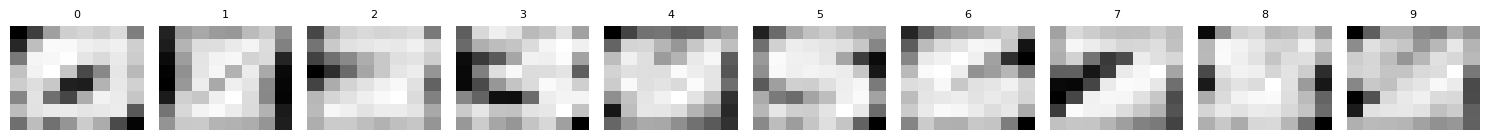

In [4]:
covariances = compute_sigma_mles(train_data,train_labels)
plot_cov_diagonal(covariances)

### 2.c compute the average conditional log-likelihood on both the train and test set

In [5]:
train_test_avg_nll(train_data, train_labels, test_data, test_labels)

,0,1,2,3,4,5,6,7,8,9
train,-68.442874,-70.139453,-41.622221,-50.828672,-69.972285,-54.308754,-72.067763,-94.208077,-41.303763,-75.369021
test,-67.037949,-68.695499,-40.308043,-49.778179,-68.327258,-53.148238,-70.308848,-92.552862,-40.186646,-73.971514


### 2.d accuracy of train and test sets

In [6]:
train_acc, test_acc = eval(train_data, train_labels, test_data, test_labels)
print(f'train accuracy: {train_acc}; test accuracy: {test_acc}')

train accuracy: 0.9814285714285714; test accuracy: 0.97275


### 2.e visualization: in the test set, show both the correct and incorrect classifications 

In [7]:
def find_correct_incorrect(train_data, train_labels, test_data, test_labels):
    # Fit the model
    means = compute_mean_mles(train_data, train_labels)
    covariances = compute_sigma_mles(train_data, train_labels)

    # preds_test
    preds = classify_data(test_data,means,covariances)

    correct_mask = test_labels == preds
    incorrect_mask = test_labels != preds

    # find the first 5 correct/incorrect
    correct_idx = np.where(correct_mask)[0][:5] 
    incorrect_idx = np.where(incorrect_mask)[0][:5]

    # make sure test labels are int (not float; just for aesthetic purpose)
    test_labels = test_labels.astype(int)
    
    # plot and print labels for correct preds
    correct_data = test_data[correct_idx]
    true_label_for_correct_data = test_labels[correct_idx]
    pred_label_for_correct_data = preds[correct_idx]
    fig, ax = plt.subplots(1,5,figsize = (10,2))
    for i in range(5):
        sns.heatmap(correct_data[i].reshape(8,8), ax = ax[i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        ax[i].set_xlabel(f'true: {true_label_for_correct_data[i]}; pred:{pred_label_for_correct_data[i]}')
    plt.suptitle('correct preds')
    plt.tight_layout()
    plt.show()

    # plot and print labels for incorrect preds
    incorrect_data = test_data[incorrect_idx]
    true_label_for_incorrect_data = test_labels[incorrect_idx]
    pred_label_for_incorrect_data = preds[incorrect_idx]
    fig, ax = plt.subplots(1,5,figsize = (10,2))
    for i in range(5):
        sns.heatmap(incorrect_data[i].reshape(8,8), ax = ax[i], cmap='gray', cbar=False, xticklabels=False, yticklabels=False)
        ax[i].set_xlabel(f'true: {true_label_for_incorrect_data[i]}; pred:{pred_label_for_incorrect_data[i]}')
    plt.suptitle('incorrect preds')
    plt.tight_layout()
    plt.show()

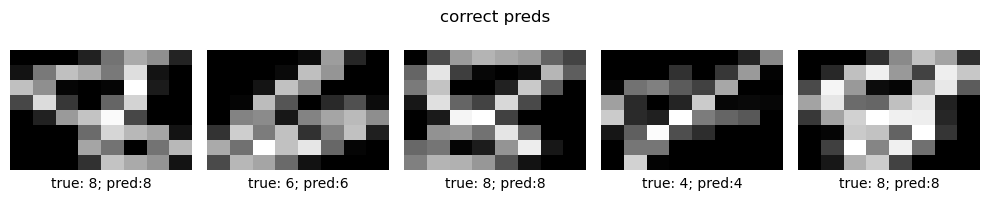

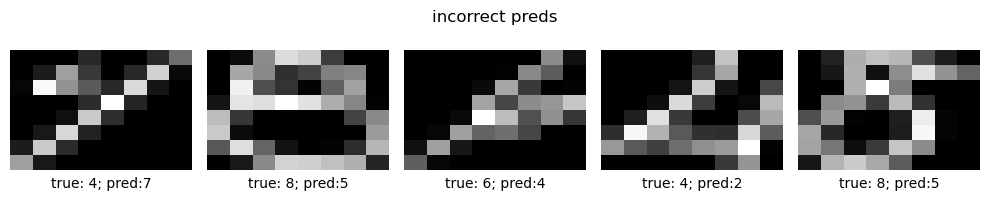

In [8]:
find_correct_incorrect(train_data, train_labels, test_data, test_labels)